In [1]:
import keras

Using TensorFlow backend.


利用Embedding层学习词嵌入

In [2]:
#将一个Embedding层实例化
from keras.layers import Embedding
embedding_layer = Embedding(1000,64)  #Embedding层至少需要两个参数，标记的个数（这里是1000即最大索引值加一）和嵌入维度（这里是64）

In [3]:
#加载IMDB数据，准备用于Embedding层
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000    #作为特征的单词个数
maxlen = 20             #在maxlen个单词后截断文本

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)      #将数据加载为整数列表

x_train = preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)  #将整数列表转换为形状为（samples,maxlen）的二维整数张量
x_test = preprocessing.sequence.pad_sequences(x_test,maxlen=maxlen)

In [4]:
#在IMDB数据上使用Embedding层和分类器
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
#指定Embedding层的最大输入长度，以便后面将嵌入输入展平，Embedding层激活的形状为(samples,maxlen,8)
model.add(Embedding(10000,8,input_length=maxlen))
model.add(Flatten())  #将三维的嵌入张量展平成形状为(samples,maxlen*8)的二维张量
model.add(Dense(1,activation='sigmoid'))   
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 63us/step - loss: 0.6686 - acc: 0.6235 - val_loss: 0.6156 - val_acc: 0.7070
Epoch 2/10
20000/20000 [==============================] - 1s 46us/step - loss: 0.5390 - acc: 0.7511 - val_loss: 0.5223 - val_acc: 0.7310
Epoch 3/10
20000/20000 [==============================] - 1s 50us/step - loss: 0.4591 - acc: 0.7879 - val_loss: 0.4966 - val_acc: 0.7480
Epoch 4/10
20000/20000 [==============================] - 1s 49us/step - loss: 0.4191 - acc: 0.8113 - val_loss: 0.4915 - val_acc: 0.7516
Epoch 5/10
20000/20000 [==============================] - 1s 48us/step - loss: 0.3919 - acc: 0.8259 - val_loss: 0.4926 - val_acc: 0.7538
Epoch 6/10
20000/20000 [==============================] - 1s 49us/step - loss: 0.3699 - acc: 0.8379 - val_loss: 0.4961 - val_acc: 0.7544
Epoch 7/10
20000/20000 [==============================] - 1s 48us/step - loss: 0.3503 - acc: 0.8480 - val_loss: 0.5014 - val_acc:

使用预训练的词嵌入



从原始文本到词嵌入

下载IMDB数据的原始文本

In [5]:
#处理IMDB原始数据的标签
import os
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir,'train')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname),encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

对数据进行分词

In [6]:
#对IMDB原始数据的文本进行分词
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100    #在100个单词后截断评论
training_samples = 200   #在200个样本上训练
validation_samples = 10000    #在10000个样本上验证
max_words = 10000     #只考虑数据集前10000个最常见的单词

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#将数据划分为训练集和验证集，但首先要打乱数据，因为一开始数据的样本是排好序的
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


下载GloVe词嵌入
https://nlp.stanford.edu/projects/glove/        glove.6B.zip  

对嵌入进行预处理

In [14]:
#解析GloVe词嵌入文件
glove_dir = 'glove_6B'

embedding_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embedding_index))

Found 400000 word vectors.


In [16]:
#准备GolVe词嵌入矩阵
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))
for word, i in word_index.items():   
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            #嵌入索引(embedding_index)中找不到的词，其嵌入向量全为0
            embedding_matrix[i] = embedding_vector

定义模型

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


在模型中加载GloVe嵌入

In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False    #需要冻结Embedding层，故trainable属性设为False

训练评估模型

In [19]:
#训练与评估
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 2.1965 - acc: 0.4900 - val_loss: 1.0798 - val_acc: 0.4949
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5772 - acc: 0.6800 - val_loss: 0.6822 - val_acc: 0.5717
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3628 - acc: 0.8550 - val_loss: 0.8445 - val_acc: 0.4981
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3193 - acc: 0.8750 - val_loss: 1.2482 - val_acc: 0.4954
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2459 - acc: 0.9150 - val_loss: 1.8876 - val_acc: 0.5053
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2375 - acc: 0.9300 - val_loss: 1.3572 - val_acc: 0.5117
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1542 - acc: 0.9650 - val_loss: 1.1117 - val_acc: 0.5027
Epoch 8/10
200/200 [========

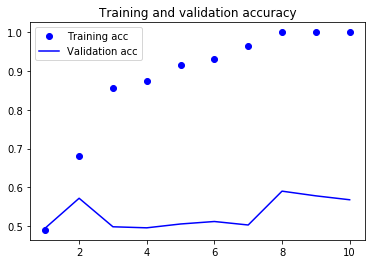

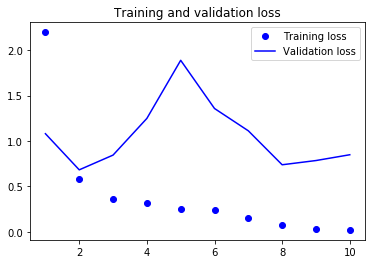

In [21]:
#绘制结果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
#不使用预训练词嵌入的情况下，训练相同的模型
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6961 - acc: 0.4750 - val_loss: 0.6920 - val_acc: 0.5170
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5425 - acc: 0.9700 - val_loss: 0.6950 - val_acc: 0.5167
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3375 - acc: 0.9700 - val_loss: 0.6970 - val_acc: 0.5228
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1657 - acc: 0.9850 - val_loss: 0.6969 - val_acc: 0.5325
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0812 - acc: 0.9950 - val_loss: 0.7008 - val_acc: 0.5301
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0435 - acc: 1.0000 - val_loss: 0.7138 - val_acc: 0.5243
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0237 - acc: 1.0000 - val_loss: 0.7084 - val_acc: 0.5247
Epoch 8/10
200/200 [========

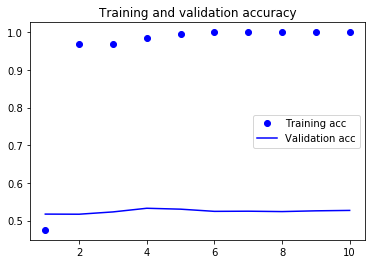

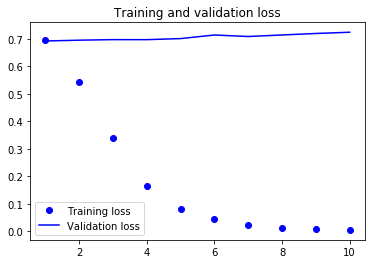

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
#对测试集数据进行分词
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [26]:
#在测试集上评估模型
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 47us/step


[0.8490505092048645, 0.5662000179290771]